In [8]:
import pandas as pd
from typing import Optional
from pathlib import Path
import gzip

### Read datasets
Use the gzip function is files ar gzipped

In [84]:
def read_ds_gzip(path: Optional[Path]=None, ds: str = "TRAIN") -> pd.DataFrame:
    """Args:
        path (Optional[Path], optional): the path to read the dataset file. Defaults to /kaggle/input/the-insa-starcraft-2-player-prediction-challenge/{ds}.CSV.gz.
        ds (str, optional): the part to read (TRAIN or TEST), to use when path is None. Defaults to "TRAIN".

    Returns:
        pd.DataFrame:
    """
    with gzip.open(f'/kaggle/input/the-insa-starcraft-2-player-prediction-challenge/{ds}.CSV.gz' if path is None else path) as f:
        max_actions = max(( len( str(c).split(",")) for c in f.readlines() ))
        f.seek(0)
        _names = ["battleneturl", "played_race"] if "TRAIN" in ds else ["played_race"]
        _names.extend(range(max_actions - len(_names)))
        return pd.read_csv(f, names=_names, dtype= str)

def read_ds(path: Optional[Path]=None, ds: str = "TRAIN"):
    """Args:
        path (Optional[Path], optional): the path to read the dataset file. Defaults to /kaggle/input/the-insa-starcraft-2-player-prediction-challenge/{ds}.CSV.gz.
        ds (str, optional): the part to read (TRAIN or TEST), to use when path is None. Defaults to "TRAIN".

    Returns:
        pd.DataFrame:
    """
    with open(f'/kaggle/input/train-sc2-keystrokes/{ds}.CSV' if path is None else path) as f:
        max_actions = max(( len( str(c).split(",")) for c in f.readlines() ))
        f.seek(0)
        _names = ["battleneturl", "played_race"] if "TRAIN" in ds else ["played_race"]
        _names.extend(range(max_actions - len(_names)))
        return pd.read_csv(f, names=_names, dtype= str)

In [85]:
features_train = read_ds_gzip(Path("data/TRAIN.CSV.GZ")) # Replace with correct path 

# features_test = read_ds("TEST")
features_train.shape #, features_test.shape

(3052, 10539)

In [86]:
features_train.head()

,battleneturl,played_race,0,1,2,3,4,5,6,7,...,10527,10528,10529,10530,10531,10532,10533,10534,10535,10536
0,http://eu.battle.net/sc2/en/profile/4234852/1/...,Protoss,Base,s,s,s,s,s,t5,Base,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,http://eu.battle.net/sc2/en/profile/3074362/1/...,Protoss,s,Base,s,s,Base,s,s,Base,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,http://eu.battle.net/sc2/en/profile/4234852/1/...,Protoss,Base,s,s,s,Base,s,hotkey30,hotkey00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,http://eu.battle.net/sc2/en/profile/3074362/1/...,Protoss,Base,s,s,Base,s,s,s,t5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,http://eu.battle.net/sc2/en/profile/4234852/1/...,Protoss,Base,s,s,s,Base,s,hotkey30,hotkey00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Dependent Variable
Our dependent variable is a categorical string; we can convert it to categories codes (number) with pd.Categorical

pd.Categorical doesn't directly modify the battleneturl to a number, instead it adds a cat.codes attribute to it. We can create a little function to convert the dependent variable from string to its category ID:

In [87]:
def to_categories(df: pd.DataFrame, col: str="battleneturl") -> None:
    """Convert col of df to a categorical column"""
    df["battleneturl"] = pd.Categorical(df["battleneturl"])
    df[[col]] = df[[col]].apply(lambda x: x.cat.codes)

#### Removing outliers
YOUR IDEAS / APPROACHES HERE.



In [88]:
to_categories(features_train)

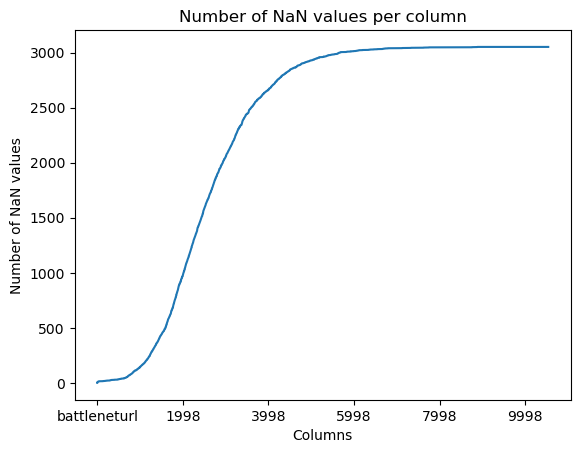

In [89]:
import matplotlib.pyplot as plt

nan_counts = features_train.isna().sum()
nan_counts.plot()
plt.xlabel('Columns')
plt.ylabel('Number of NaN values')
plt.title('Number of NaN values per column')
plt.show()

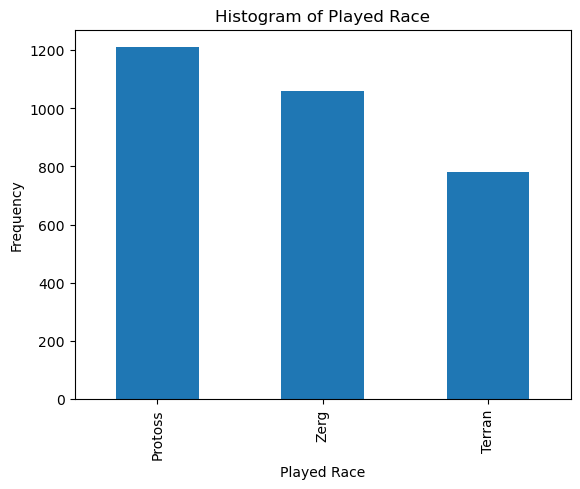

In [8]:
features_train['played_race'].value_counts().plot(kind='bar')
plt.xlabel('Played Race')
plt.ylabel('Frequency')
plt.title('Histogram of Played Race')
plt.show()

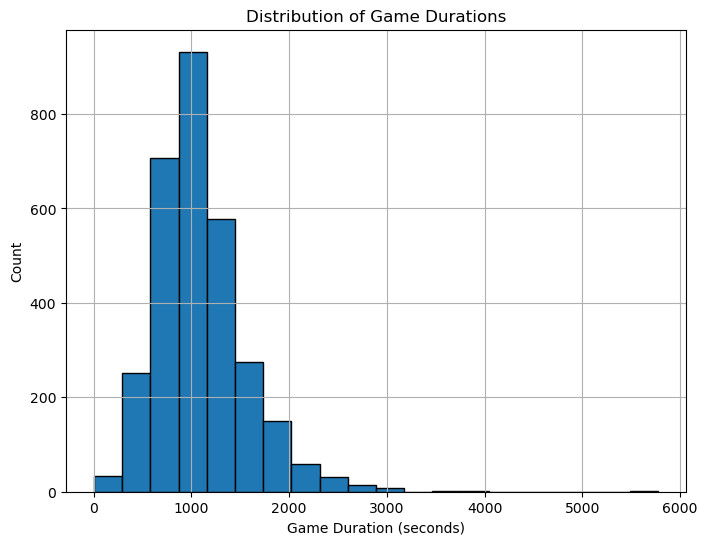

In [90]:

durations = []

# Iterate over each row in the dataframe
for _, row in features_train.iterrows():
    # Convert the row to a list (strings, possibly some NaN if missing)
    row_list = row.tolist()

    # Filter columns that start with "t" (e.g., "t10", "t120", etc.)
    time_tokens = [
        col for col in row_list if isinstance(col, str) and col.startswith("t")
    ]

    if time_tokens:
        # Get the last time token in the row
        last_time_token = time_tokens[-1]
        # Convert from e.g. "t135" -> integer 135
        duration = int(last_time_token[1:])
        durations.append(duration)
    else:
        # If no time tokens, we can append None or skip.
        durations.append(None)

# Store the durations in the dataframe as a new column for convenience
features_train["duration"] = durations

# Drop rows without a valid duration
features_train.dropna(subset=["duration"], inplace=True)

# Plot the distribution as a histogram
plt.figure(figsize=(8, 6))
features_train["duration"].plot(kind="hist", bins=20, edgecolor="black")
plt.title("Distribution of Game Durations")
plt.xlabel("Game Duration (seconds)")
plt.ylabel("Count")
plt.grid(True)
plt.show()


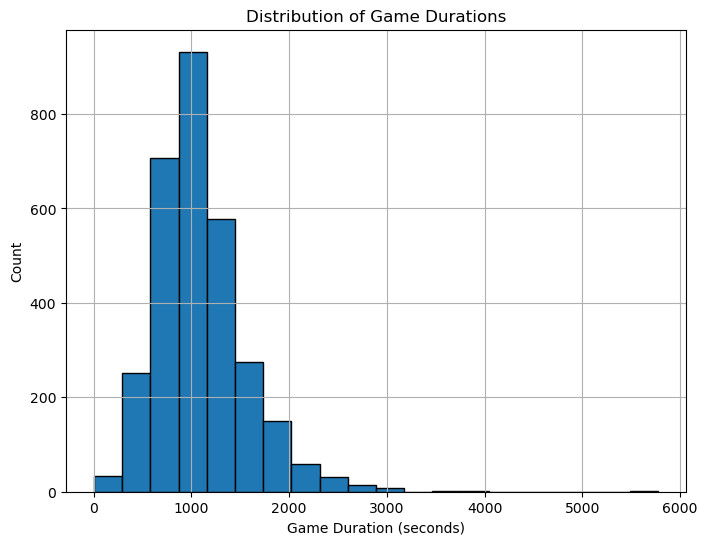

In [91]:
features_train_filtered = features_train
    

# Plot the distribution as a histogram
plt.figure(figsize=(8, 6))
features_train_filtered['duration'].plot(kind='hist', bins=20, edgecolor='black')
plt.title('Distribution of Game Durations')
plt.xlabel('Game Duration (seconds)')
plt.ylabel('Count')
plt.grid(True)
plt.show()

In [37]:
import pandas as pd

# Display global statistics about the dataset
print("Total number of rows (games):", len(features_train_filtered))

# If you have a unique player identifier (e.g. 'battleneturl')
if "battleneturl" in features_train_filtered.columns:
    print("Number of unique players:", features_train_filtered["battleneturl"].nunique())

# If you have a race column (e.g. 'played_race')
if "played_race" in features_train_filtered.columns:
    print("Number of unique races:", features_train_filtered["played_race"].nunique(), "\n")
    print("=== Race Distribution ===\n", features_train_filtered["played_race"].value_counts(), "\n")

# Basic statistics for durations
if "duration" in features_train_filtered.columns:
    print("=== Duration Summary ===")
    print(features_train_filtered["duration"].agg(["min", "max", "mean", "std"]))

    # Example: Group by race to see duration stats per race
    if "played_race" in features_train_filtered.columns:
        print("\n=== Duration by Race ===")
        print(features_train_filtered.groupby("played_race")["duration"].agg(["min", "max", "mean", "std"]))


Total number of rows (games): 2981
Number of unique players: 200
Number of unique races: 3 

=== Race Distribution ===
 played_race
Protoss    1188
Zerg       1030
Terran      763
Name: count, dtype: int64 

=== Duration Summary ===
min      350.000000
max     5770.000000
mean    1109.600805
std      460.646422
Name: duration, dtype: float64

=== Duration by Race ===
               min     max        mean         std
played_race                                       
Protoss      350.0  3805.0  1065.47138  424.429431
Terran       355.0  5770.0  1166.55308  460.431848
Zerg         350.0  5770.0  1118.31068  494.976033


In [92]:
# drop duration column
features_train_filtered.drop(columns=['duration'], inplace=True)

In [93]:
# Make a deep copy to avoid the SettingWithCopyWarning
features_train_filtered = features_train_filtered.copy()

# Now safely do your assignments
action_cols = features_train_filtered.columns[2:]
features_train_filtered["actions"] = (
    features_train_filtered[action_cols]
    .apply(lambda row: [x for x in row if pd.notna(x)], axis=1)
)

features_train_filtered.drop(columns=action_cols, inplace=True)

In [94]:
# Define a function to filter actions up to "t900"
def filter_actions(row):
    if "t900" in row:  # Check if "t900" exists in the actions list
        t900_index = row.index("t900")  # Find the index of "t900"
        return row[:t900_index + 1]  # Keep all actions up to and including "t900"
    return row  # If "t900" doesn't exist, keep the entire row

# Apply the filter_actions function to the "actions" column
features_train_filtered["actions"] = features_train_filtered["actions"].apply(filter_actions)

### Custom features

In [95]:
def chunkify_actions(action_list):
    """
    Given a list of actions (e.g., ["Base", "s", "s", "t5", "hotkey30", "t10", ...]),
    produce a list of tuples (start_time, end_time, actions_in_chunk).
    If we see 't5', that means the chunk boundary is 5 seconds, etc.
    """
    chunks = []
    current_time = 0
    chunk_actions = []

    def parse_time_marker(a):
        # e.g. 't5' -> int("5")
        return int(a[1:])

    for a in action_list:
        if a.startswith("t"):
            # We hit a time boundary
            end_time = parse_time_marker(a)
            if chunk_actions:
                chunks.append((current_time, end_time, chunk_actions))
            # Move forward
            current_time = end_time
            chunk_actions = []
        else:
            # It's a normal action
            chunk_actions.append(a)

    # If leftover actions exist after the last tXX
    # We'll treat them as from current_time to current_time (0-length),
    # or you can define a “max game time” if known. For now, let's store them anyway.
    if chunk_actions:
        chunks.append((current_time, current_time, chunk_actions))

    return chunks


In [100]:
def compute_features_per_chunk(chunks):
    """
    Given a list of (start_t, end_t, actions_in_chunk),
    classify them into early/mid/late, count relevant actions,
    compute average in each phase.
    """
    # Phase boundaries
    START_MAX = 60 # 1 minutes
    EARLY_MAX = 360  # 6 minutes
    MID_MAX = 900  # 15 minutes

    # We'll accumulate total counts and total durations (in seconds) for each phase
    phases = ["start", "early", "mid"]

    base_keys = {
        "hk_created": 0,
        "hk_used":    0,
        "base":       0,
        "mineral":    0,
        "other":      0
    }

    phase_counts = {
        ph: {
            **{f"hk_{i}": 0 for i in range(10)},
            **base_keys
        }
        for ph in phases
    }

    phase_durations = {ph: 0 for ph in phases}

    def get_phase(t):
        if t < START_MAX:
            return "start"
        elif t < EARLY_MAX:
            return "early"
        elif t < MID_MAX:
            return "mid"

    for start_t, end_t, acts in chunks:
        if (start_t >= MID_MAX):
            break

        # Simple approach: classify chunk by its start time (some people use midpoint)
        phase = get_phase(start_t)
        # Avoid zero durations => set it to at least 1 second
        duration = max(1, end_t - start_t)

        # Count actions in this chunk
        c_hk_pressed = {i: 0 for i in range(10)}
        c_hk_created = 0
        c_hk_used = 0
        c_base = 0
        c_mineral = 0
        c_other = 0

        for a in acts:
            if a.startswith("hotkey"):
                key = int(a[-2])
                c_hk_pressed[key] += 1
                if a.endswith("0"):
                    c_hk_created += 1
                elif a.endswith("2"):
                    c_hk_used += 1
            elif a in ["sBase", "Base"]:
                c_base += 1
            elif a in ["sMineral", "SingleMineral"]:
                c_mineral += 1
            elif a == "s":
                c_other += 1
            else:
                # some other action not relevant here
                pass

        for i in range(10):
            phase_counts[phase][f"hk_{i}"] += c_hk_pressed[i]
        phase_counts[phase]["hk_created"] += c_hk_created
        phase_counts[phase]["hk_used"] += c_hk_used
        phase_counts[phase]["base"] += c_base
        phase_counts[phase]["mineral"] += c_mineral
        phase_counts[phase]["other"] += c_other

        phase_durations[phase] += duration

    # Now compute the final average for each phase
    # e.g.  (count / total_duration_in_phase)
    feats = {}
    for phase in phases:
        dur = phase_durations[phase]
        pc = phase_counts[phase]
        if dur == 0:
            # no data for that phase
            for i in range(10):
                feats[f"{phase}_hk_{i}"] = 0
            feats[f"{phase}_base"] = 0
            feats[f"{phase}_mineral"] = 0
            feats[f"{phase}_other"] = 0
        else:
            for i in range(10):
                feats[f"{phase}_hk_{i}"] = (pc[f"hk_{i}"] / dur)
            feats[f"{phase}_hk_created"] = (pc["hk_created"] / dur)
            feats[f"{phase}_hk_used"] = (pc["hk_used"] / dur)
            feats[f"{phase}_base"] = (pc["base"] / dur)
            feats[f"{phase}_mineral"] = (pc["mineral"] / dur)
            feats[f"{phase}_other"] = (pc["other"] / dur)

    return feats

In [101]:
def compute_all_features(row):
    """
    row is a single Pandas row with:
       row["actions"] = list of action strings
       row["battleneturl"], row["played_race"], etc. if needed
    Returns a dict of feature_name -> value
    """
    chunks = chunkify_actions(row)
    feats = compute_features_per_chunk(chunks)
    
    # You can also include the player's ID or race in the returned features if desired
    return feats

# Apply to entire DataFrame
features_df = features_train_filtered["actions"].apply(compute_all_features).apply(pd.Series)

print(features_df.head())

# Combine with the original df if you like
result_df = pd.concat([features_train_filtered, features_df], axis=1)
print(result_df.head())


   start_hk_0  start_hk_1  start_hk_2  start_hk_3  start_hk_4  start_hk_5  \
0    0.028571    0.000000         0.0    0.342857         0.0         0.0   
1    0.000000    0.083333         0.0    0.650000         0.0         0.0   
2    0.020000    0.000000         0.0    0.680000         0.0         0.0   
3    0.000000    0.050000         0.0    0.550000         0.0         0.0   
4    0.020000    0.000000         0.0    0.660000         0.0         0.0   

   start_hk_6  start_hk_7  start_hk_8  start_hk_9  ...  mid_hk_5  mid_hk_6  \
0         0.0         0.0         0.0         0.0  ...  0.038095  0.005714   
1         0.0         0.0         0.0         0.0  ...  0.000000  0.000000   
2         0.0         0.0         0.0         0.0  ...  0.131429  0.020952   
3         0.0         0.0         0.0         0.0  ...  0.000000  0.000000   
4         0.0         0.0         0.0         0.0  ...  0.005556  0.000000   

   mid_hk_7  mid_hk_8  mid_hk_9  mid_hk_created  mid_hk_used  mid_ba

In [102]:
features_df["battleneturl"] = features_train_filtered["battleneturl"]
features_df["race"] = features_train_filtered["played_race"]

In [103]:
print(features_df.head())
copy_df = features_df.copy()

   start_hk_0  start_hk_1  start_hk_2  start_hk_3  start_hk_4  start_hk_5  \
0    0.028571    0.000000         0.0    0.342857         0.0         0.0   
1    0.000000    0.083333         0.0    0.650000         0.0         0.0   
2    0.020000    0.000000         0.0    0.680000         0.0         0.0   
3    0.000000    0.050000         0.0    0.550000         0.0         0.0   
4    0.020000    0.000000         0.0    0.660000         0.0         0.0   

   start_hk_6  start_hk_7  start_hk_8  start_hk_9  ...  mid_hk_7  mid_hk_8  \
0         0.0         0.0         0.0         0.0  ...       0.0  0.000000   
1         0.0         0.0         0.0         0.0  ...       0.0  0.019048   
2         0.0         0.0         0.0         0.0  ...       0.0  0.000000   
3         0.0         0.0         0.0         0.0  ...       0.0  0.000000   
4         0.0         0.0         0.0         0.0  ...       0.0  0.000000   

   mid_hk_9  mid_hk_created  mid_hk_used  mid_base  mid_mineral  mid

### Getting features...

Building a mini framework to read our Dataframe and convert it to features.

Now we will create features out of the dataset.

FeaturesGetter iterates over an ActionsDataLoader (yield every actions between two 't[xx]') and apply a set of Feature contained in a FeaturePool. At the end, it gets metrics over the values registered by each features in the feature pool.

Defining lambdas to convert dataset to features
We create basic features, corresponding to the mean of each action played per timestamp plus the mean of all actions together

Now it's ready to be put into a function that'll get all the features from the initial dataframe and return a new dataframe containing only those features. FeaturesGetter gets one extra feature from that we created, which is max_time, corresponding to the "xx" of the last "txx" seen.

### Handling string
The race_played column can only take three values; instead of converting it to categorical as we did with our dependent variable, we will instead convert it to dummy variables: we one-hot encode each race. It will not add many columns to our dataframe (only three) but will allow the decision trees to split much faster on the race (on only one binary split).

In [111]:
def get_dummies(df: pd.DataFrame):
    """Converts textual columns to one-hot encoded vectors (one column per possible value)"""
    df = pd.get_dummies(df, columns=["race"])
    return df

Function preprocess creates a pipeline of all the function we just implemented: it create the features, converts the race to dummy variables and the dependent variable to category codes.

In [110]:
features_df = get_dummies(features_df)

KeyError: "None of [Index(['race'], dtype='object')] are in the [columns]"

In [106]:
features_df.head()

,start_hk_0,start_hk_1,start_hk_2,start_hk_3,start_hk_4,start_hk_5,start_hk_6,start_hk_7,start_hk_8,start_hk_9,...,mid_hk_9,mid_hk_created,mid_hk_used,mid_base,mid_mineral,mid_other,battleneturl,race_Protoss,race_Terran,race_Zerg
0,0.028571,0.000000,0.0,0.342857,0.0,0.0,0.0,0.0,0.0,0.0,...,0.003810,0.057143,0.912381,0.032381,0.001905,0.348571,53,True,False,False
1,0.000000,0.083333,0.0,0.650000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.005714,0.057143,0.857143,0.007619,0.000000,0.264762,29,True,False,False
2,0.020000,0.000000,0.0,0.680000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.005714,0.032381,0.855238,0.076190,0.001905,0.396190,53,True,False,False
3,0.000000,0.050000,0.0,0.550000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.024074,0.062963,0.818519,0.027778,0.000000,0.398148,29,True,False,False
4,0.020000,0.000000,0.0,0.660000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.055556,0.672222,0.000000,0.000000,0.288889,53,True,False,False


## ML !!!

In [74]:
import pandas as pd

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score

In [107]:

feature_cols = [c for c in features_df.columns if c not in ['battleneturl']]
X = features_df[feature_cols]
y = features_df['battleneturl'].values

# Split into train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y
)

In [108]:
param_distributions = {
    'n_estimators': [100, 200, 300, 500, 700],
    'max_depth': [10, 15, 20, 25, None],
    'min_samples_split': [2, 4, 8, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', 0.33, 0.5]
}

In [109]:
rf = RandomForestClassifier(random_state=42)

random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_distributions,
    n_iter=30,            # how many random samples of params to try
    scoring='accuracy',   # or 'f1_macro', etc., depending on your metric
    cv=5,                 # 5-fold cross-validation
    verbose=1,
    n_jobs=-1,            # use all CPU cores
    random_state=42
)

random_search.fit(X_train, y_train)
print("Best Params:", random_search.best_params_)
print("Best CV Accuracy:", random_search.best_score_)


Fitting 5 folds for each of 30 candidates, totalling 150 fits


c:\Users\Utilisateur\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


ValueError: 
All the 150 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
150 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Utilisateur\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Utilisateur\anaconda3\Lib\site-packages\sklearn\ensemble\_forest.py", line 345, in fit
    X, y = self._validate_data(
           ^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Utilisateur\anaconda3\Lib\site-packages\sklearn\base.py", line 584, in _validate_data
    X, y = check_X_y(X, y, **check_params)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Utilisateur\anaconda3\Lib\site-packages\sklearn\utils\validation.py", line 1106, in check_X_y
    X = check_array(
        ^^^^^^^^^^^^
  File "c:\Users\Utilisateur\anaconda3\Lib\site-packages\sklearn\utils\validation.py", line 921, in check_array
    _assert_all_finite(
  File "c:\Users\Utilisateur\anaconda3\Lib\site-packages\sklearn\utils\validation.py", line 161, in _assert_all_finite
    raise ValueError(msg_err)
ValueError: Input X contains NaN.
RandomForestClassifier does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values


In [79]:
best_rf = random_search.best_estimator_
y_pred = best_rf.predict(X_test)
test_acc = accuracy_score(y_test, y_pred)
print(f"Random Forest Test Accuracy: {test_acc*100:.2f}%")

Random Forest Test Accuracy: 93.43%


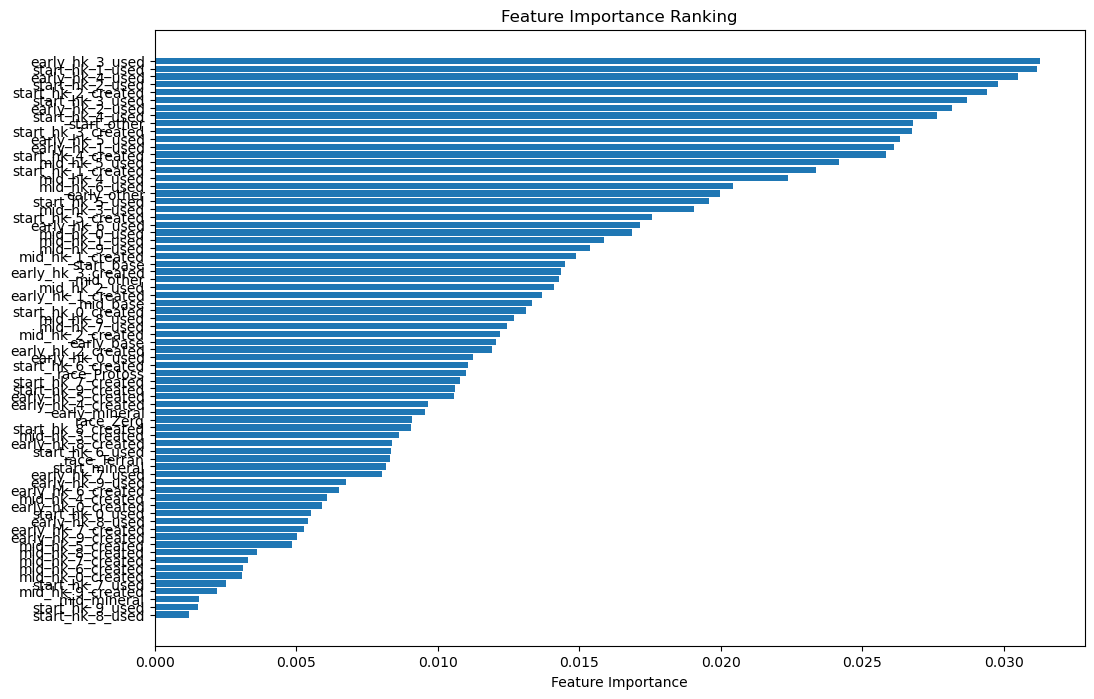

In [80]:
# Feature Importance - Mean Decrease in Impurity
importances = best_rf.feature_importances_
feature_names = X.columns

feature_importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values(by='importance', ascending=False)

# Plot Mean Decrease in Impurity
plt.figure(figsize=(12, 8))
plt.barh(feature_importance_df['feature'], feature_importance_df['importance'])
plt.xlabel('Feature Importance')
plt.title('Feature Importance Ranking')
plt.gca().invert_yaxis()
plt.show()

In [81]:
from sklearn.inspection import permutation_importance


# Permutation Importance
results = permutation_importance(best_rf, X_test, y_test, scoring='accuracy', n_repeats=30, random_state=42, n_jobs=-1)

perm_importance = pd.DataFrame({
    'feature': X.columns,
    'importance_mean': results.importances_mean,
    'importance_std': results.importances_std
}).sort_values(by='importance_mean', ascending=False)

# Plot Permutation Importance
plt.figure(figsize=(12, 8))
plt.barh(perm_importance['feature'], perm_importance['importance_mean'], xerr=perm_importance['importance_std'])
plt.xlabel('Permutation Importance')
plt.title('Permutation Feature Importance Ranking')
plt.gca().invert_yaxis()
plt.show()


KeyboardInterrupt: 

In [39]:
# Save the model to disk
import pickle
with open('random_forest_model.pkl', 'wb') as file:
    pickle.dump(best_rf, file)